# Near duplicate image detection

This notebook will give an overview of how perceptual image hashes can be used to detect duplicate and near duplicate images.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[pipeline] textdistance

# Get test data
!wget -N https://github.com/neuml/txtai/releases/download/v3.5.0/tests.tar.gz
!tar -xvzf tests.tar.gz

# Generate hashes

The example below generates perceptual image hashes for a list of images.

In [ ]:
import glob

from PIL import Image

from txtai.pipeline import ImageHash

def show(image):
  width, height = image.size
  return image.resize((int(width / 2.25), int((width / 2.25) * height / width)))

# Get and scale images
images = [Image.open(image) for image in glob.glob('txtai/*jpg')]

# Create image pipeline
ihash = ImageHash()

# Generate hashes
hashes = ihash(images)
hashes

['ffffdf0700010100',
 '78f8f8d8f8f8f8f0',
 '00000006fefcfc30',
 '000000c0feffff00',
 '63263c183ce66742',
 '60607072fe78cc00',
 '0859dd04bfbfbf00',
 '0000446c6f2f2724',
 'ff9f010909010101',
 'ff9d8140c070ffff']

# Hash search

Next we'll generate a search hash to use to find similar near-duplicate images. This logic takes a section of an image and generates a hash for that

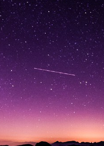

In [ ]:
# Get test image index
index = hashes.index('000000c0feffff00')

# Select portion of image
width, height = images[index].size

# Get dimensions for middle of image
left = (width - width/3)/2
top = (height - height/1.35)/2
right = (width + width/3)/2
bottom = (height + height/1.35)/2

# Crop image
search = images[index].crop((left, top, right, bottom))
show(search)

Now let's compare the hash to all the image hashes using [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). We'll use the [textdistance](https://github.com/life4/textdistance) library for that. 

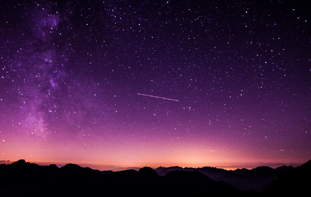

In [ ]:
import textdistance

# Find closest image hash using textdistance
shash = ihash(search)

# Calculate distances for search hash
distances = [int(textdistance.levenshtein.distance(h, shash)) for h in hashes]

# Show closest image hash
low = min(distances)
show(images[distances.index(low)])

And as expected, the closest match is the original full image!

# Generate hashes with Embeddings indexes

Next we'll add a custom field with a perceptual image hash and a custom SQL function to calculate Levenshtein distance. An index of images is built and then a search query run using the distance from the same search hash.

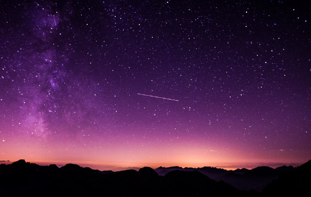

In [ ]:
from txtai.embeddings import Embeddings

def distance(a, b):
  if a and not b:
    return len(a)
  if not a and b:
    return len(b)
  if not a and not b:
    return 0
  
  return int(textdistance.levenshtein.distance(a, b))

# Create embeddings index with content enabled. The default behavior is to only store indexed vectors.
embeddings = Embeddings({"path": "sentence-transformers/nli-mpnet-base-v2", "content": True, "objects": "image", "functions": [distance]})

# Create an index for the list of text
embeddings.index([(uid, {"object": image, "text": ihash(image)}, None) for uid, image in enumerate(images)])

# Find image that is closest to hash
show(embeddings.search(f"select object from txtai order by distance(text, '{shash}')")[0]["object"])

And just like above, the best match is the original full image.

# Wrapping up

This notebook introduced perceptual image hashing. These hashes can be used to detect near-duplicate images. This method is not backed by machine learning models and not intended to find conceptually similar images. But for tasks looking to find similar/near-duplicate images this method is fast and does the job!